adding ideograms...
chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrM
chrX
chrY
adding genes...
chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrX
chrY


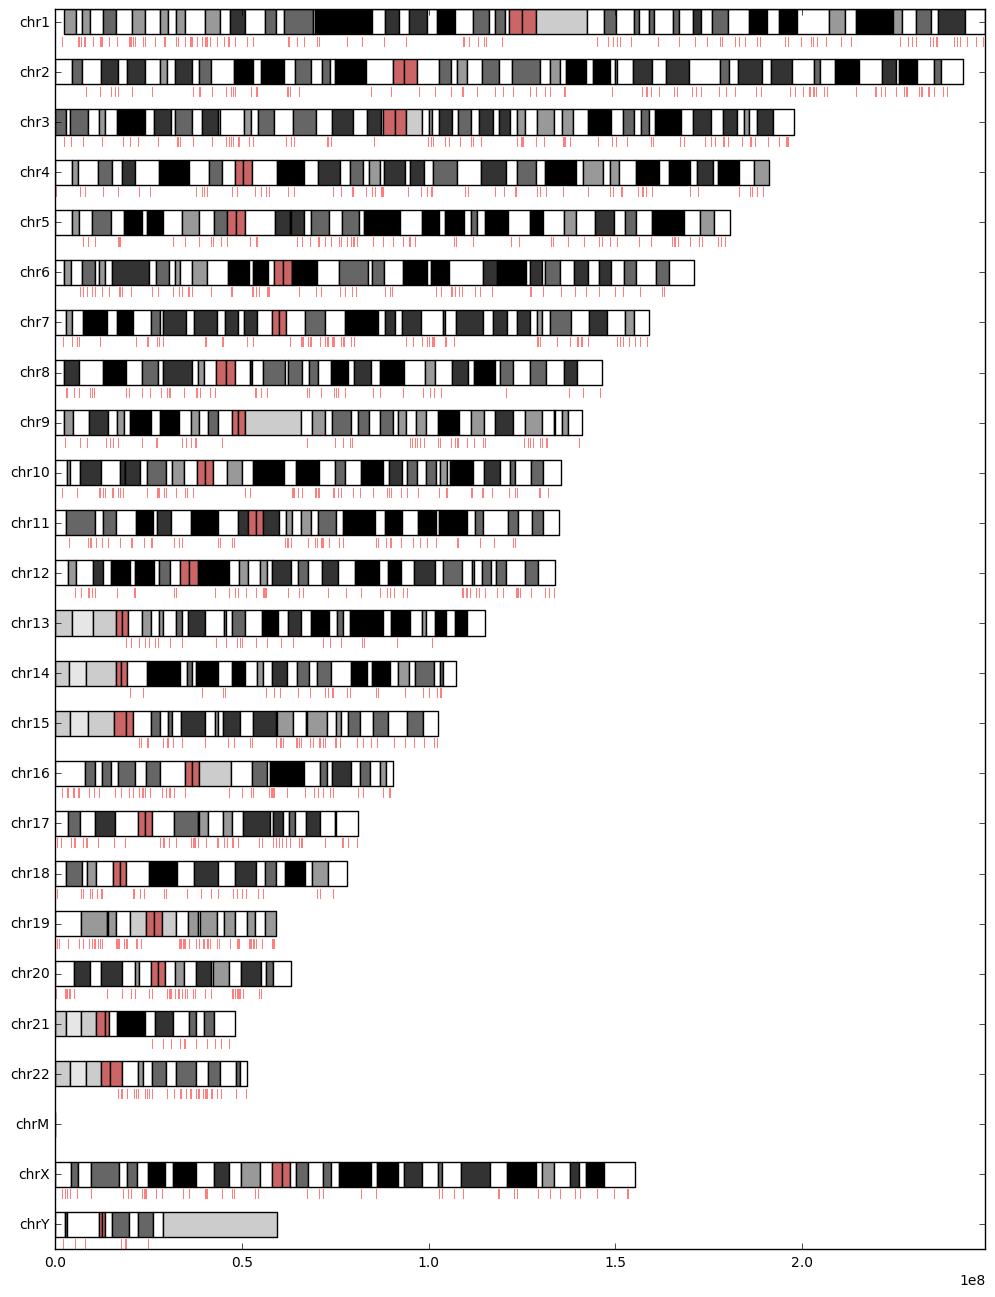

In [28]:
#!/usr/bin/env python

"""
Demonstrates plotting chromosome ideograms and genes (or any features, really)
using matplotlib.
1) Assumes a file from UCSC's Table Browser from the "cytoBandIdeo" table,
saved as "ideogram.txt". Lines look like this::
    #chrom  chromStart  chromEnd  name    gieStain
    chr1    0           2300000   p36.33  gneg
    chr1    2300000     5300000   p36.32  gpos25
    chr1    5300000     7100000   p36.31  gneg
2) Assumes another file, "ucsc_genes.txt", which is a BED format file
   downloaded from UCSC's Table Browser. This script will work with any
   BED-format file.
"""

from matplotlib import pyplot as plt
from matplotlib.collections import BrokenBarHCollection
import pandas


# Here's the function that we'll call for each dataframe (once for chromosome
# ideograms, once for genes).  The rest of this script will be prepping data
# for input to this function
#
def chromosome_collections(df, y_positions, height, **kwargs):
    """
    Yields BrokenBarHCollection of features that can be added to an Axes
    object.
    Parameters
    ----------
    df : pandas.DataFrame
        Must at least have columns ['chrom', 'start', 'end', 'color']. If no
        column 'width', it will be calculated from start/end.
    y_positions : dict
        Keys are chromosomes, values are y-value at which to anchor the
        BrokenBarHCollection
    height : float
        Height of each BrokenBarHCollection
    Additional kwargs are passed to BrokenBarHCollection
    """
    del_width = False
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
        print(chrom)
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']


# Height of each ideogram
chrom_height = 1.5

# Spacing between consecutive ideograms
chrom_spacing = 2

# Height of the gene track. Should be smaller than `chrom_spacing` in order to
# fit correctly
gene_height = 0.8

# Padding between the top of a gene track and its corresponding ideogram
gene_padding = 0.1

# Width, height (in inches)
figsize = (12, 16)

# Decide which chromosomes to use
#chromosome_list = ['chr%s' % i for i in range(1, 23) + ['M', 'X', 'Y']]
chromosome_list = ['chr%s' % i for i in range(1, 23)]
chromosome_list += (['chr%s'% i for i in ['M', 'X', 'Y']])

# Keep track of the y positions for ideograms and genes for each chromosome,
# and the center of each ideogram (which is where we'll put the ytick labels)
ybase = 0
chrom_ybase = {}
gene_ybase = {}
chrom_centers = {}

# Iterate in reverse so that items in the beginning of `chromosome_list` will
# appear at the top of the plot
for chrom in chromosome_list[::-1]:
    chrom_ybase[chrom] = ybase
    chrom_centers[chrom] = ybase + chrom_height / 2.
    gene_ybase[chrom] = ybase - gene_height - gene_padding
    ybase += chrom_height + chrom_spacing

# Read in ideogram.txt, downloaded from UCSC Table Browser
ideo = pandas.read_table(
    '../download/genome/ideogram.txt',
    skiprows=1,
    names=['chrom', 'start', 'end', 'name', 'gieStain']
)

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

# Add a new column for width
ideo['width'] = ideo.end - ideo.start

# Colors for different chromosome stains
color_lookup = {
    'gneg': (1., 1., 1.),
    'gpos25': (.6, .6, .6),
    'gpos50': (.4, .4, .4),
    'gpos75': (.2, .2, .2),
    'gpos100': (0., 0., 0.),
    'acen': (.8, .4, .4),
    'gvar': (.8, .8, .8),
    'stalk': (.9, .9, .9),
}

# Add a new column for colors
ideo['colors'] = ideo['gieStain'].apply(lambda x: color_lookup[x])

# Same thing for genes
#genes = pandas.read_table(
#    '../download/genome/knownGene_hg19.bed',
#    names=['chrom', 'start', 'end', 'name'],
#    usecols=range(4))

genes = pandas.read_hdf("../storage/repeatmasker_staging.hdf", "SINE_Alu_bed")

genes = genes[genes.chrom.apply(lambda x: x in chromosome_list)]
genes['width'] = genes.end - genes.start
genes['colors'] = 'red'

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

# Now all we have to do is call our function for the ideogram data...
print("adding ideograms...")
for collection in chromosome_collections(ideo, chrom_ybase, chrom_height):
    ax.add_collection(collection)

# ...and the gene data
print("adding genes...")
for collection in chromosome_collections(
        genes, gene_ybase, gene_height, alpha=0.5, linewidths=0.0
):
    ax.add_collection(collection)

# Axes tweaking
ax.set_yticks([chrom_centers[i] for i in chromosome_list])
ax.set_yticklabels(chromosome_list)
ax.axis('tight')
plt.show()


In [17]:
lst = ['chr%s' % i for i in range(1, 23)]
lst += (['chr%s'% i for i in ['M', 'X', 'Y']])